# Gesture Recognition

Build a 3D Conv model that will be able to predict the 5 gestures correctly. 

The gestures are aimed to control Smart TV operations 

By: Ashutosh Sharma(Deep Learning C-36 Batch)

In [1]:
# Importing required Libraries
import numpy as np
import pandas as pd
import os
import imageio
import datetime
import cv2
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
# Import all the required Keras modules
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, Input
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50

In [5]:
#importing data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In this block, we read the folder names for training and validation. We also set the batch_size here. 

In [6]:
train_doc = np.random.permutation(open('/content/gdrive/MyDrive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/gdrive/MyDrive/Project_data/val.csv').readlines())
batch_size = 50

train_path = '/content/gdrive/MyDrive/Project_data/train' # this will be the source_path in generator function
val_path = '/content/gdrive/MyDrive/Project_data/val'

Analysing Images

In [7]:
# Creating separate data frames for different gesture classes
train_df = pd.read_csv('/content/gdrive/MyDrive/Project_data/train.csv',header = None)
train_df = train_df[0].str.split(pat = ';',expand = True)
train_df.rename(columns = {0: 'name', 1: 'gesture', 2: 'class'},inplace = True)
train_df.head(100)

,name,gesture,class
0,WIN_20180925_17_08_43_Pro_Left_Swipe_new,Left_Swipe_new,0
1,WIN_20180925_17_18_28_Pro_Left_Swipe_new,Left_Swipe_new,0
2,WIN_20180925_17_18_56_Pro_Left_Swipe_new,Left_Swipe_new,0
3,WIN_20180925_17_19_51_Pro_Left_Swipe_new,Left_Swipe_new,0
4,WIN_20180925_17_20_14_Pro_Left_Swipe_new,Left_Swipe_new,0
...,...,...,...
95,WIN_20180926_17_43_30_Pro_Left_Swipe_new,Left_Swipe_new,0
96,WIN_20180925_17_17_26_Pro_Right_Swipe_new,Right_Swipe_new,1
97,WIN_20180925_17_18_25_Pro_Right_Swipe_new,Right_Swipe_new,1
98,WIN_20180925_17_19_19_Pro_Right_Swipe_new,Right_Swipe_new,1


In [ ]:
#Checking for any imbalance
train_df['class'].value_counts()

1    137
3    137
0    136
2    130
4    123
Name: class, dtype: int64

There Re no major imbalances seen

In [ ]:
# Analysing imagee shapes
shape1 = 0
shape2 = 0
shape3 = 0

for folder in train_df['name']:
  temp = os.listdir('/content/gdrive/MyDrive/Project_data/train'+'/'+ folder)
  if(temp == []):
    print("\n Following folder is empty:" + folder)
  if(imageio.imread('/content/gdrive/MyDrive/Project_data/train'+'/'+ folder +'/'+temp[2]).shape == (120,160,3)):
    shape1 += 1
  elif(imageio.imread('/content/gdrive/MyDrive/Project_data/train'+'/'+ folder +'/'+temp[2]).shape == (360,360,3)):
    shape2 += 1
  else:
    shape3 += 1 
         
print('Number of images with shape 120x160x3:', shape1)
print('Number of images with shape 360x360x3:', shape2)
print('Number of images with other shapes   :', shape3)

Number of images with shape 120x160x3: 479
Number of images with shape 360x360x3: 184
Number of images with other shapes   : 0


All the images present in the folder are of size either 120x160 or 360x360. These images are needed to be brought into a common size say 120x120

We need to analyze if all 30 images are required or not as majority of images from the middle should suffice as a complete particular action is seen around those images

Images are either 120x120x3 or 360x360x3
So lets reshape the images into 120x120x3 resolution

Image Augmentation and Normalization

In [8]:
# Writing a custom function to show the images and their augmentation
def imageview(class_img, source_path):
    
    # Get all 30 images in the folder
    images = os.listdir(source_path+'/'+ class_img)
    # Select one image among the 30 images
    image = imageio.imread(source_path+'/'+ class_img +'/'+images[14])
    print('original:',image.shape)
    
    # Resize the image
    resized_img = cv2.resize(image, (120,120), interpolation = cv2.INTER_AREA)
    print('resized:',resized_img.shape)
    
    # Apply Gaussian Blur on the image
    blur_image = cv2.GaussianBlur(resized_img, (3,3), 3)
    print('blurred:',blur_image.shape)
    
    # Image Edge Detection
    edge_image = cv2.Canny(blur_image, 75, 150)
    # Get it into shape of 120x120x3 to maintain same shape through out (Canny removes the channels)
    edge_image1 = cv2.cvtColor(edge_image, cv2.COLOR_GRAY2BGR)
    print('edge:',edge_image1.shape)
    
    # Normalize the image
    norm_img = resized_img/255
    print('normalized:',norm_img.shape)
    
    fig = plt.figure(figsize = (20, 30))
    
    plt.subplot(151)
    plt.title('Original')
    plt.imshow(image)
    
    plt.subplot(152)
    plt.title('Resized')
    plt.imshow(resized_img) 
     
    plt.subplot(153)
    plt.title('Gaussian Blur')
    plt.imshow(blur_image)
    
    plt.subplot(154)
    plt.title('Edges')
    plt.imshow(edge_image1, cmap = 'gray')
    
    plt.subplot(155)
    plt.title('Normalized')
    plt.imshow(norm_img)

    plt.show()

In [9]:
# Consider two images (one with 120x160x3 and another with 360x360x3) each from every class for analysis
class_0_120 = train_df[train_df['class']=='0'].reset_index()['name'][2]
class_0_360 = train_df[train_df['class']=='0'].reset_index()['name'][135]
class_1_120 = train_df[train_df['class']=='1'].reset_index()['name'][1]
class_1_360 = train_df[train_df['class']=='1'].reset_index()['name'][134]
class_2_120 = train_df[train_df['class']=='2'].reset_index()['name'][3]
class_2_360 = train_df[train_df['class']=='2'].reset_index()['name'][121]
class_3_120 = train_df[train_df['class']=='3'].reset_index()['name'][4]
class_3_360 = train_df[train_df['class']=='3'].reset_index()['name'][132]
class_4_120 = train_df[train_df['class']=='4'].reset_index()['name'][5]
class_4_360 = train_df[train_df['class']=='4'].reset_index()['name'][111]

Image for Swipe Left:


original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


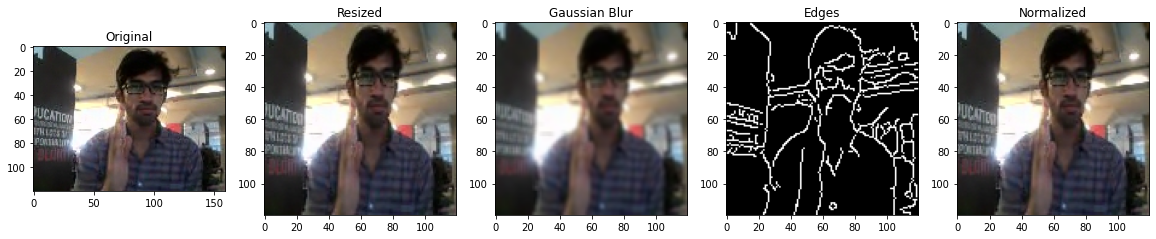

original: (360, 360, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


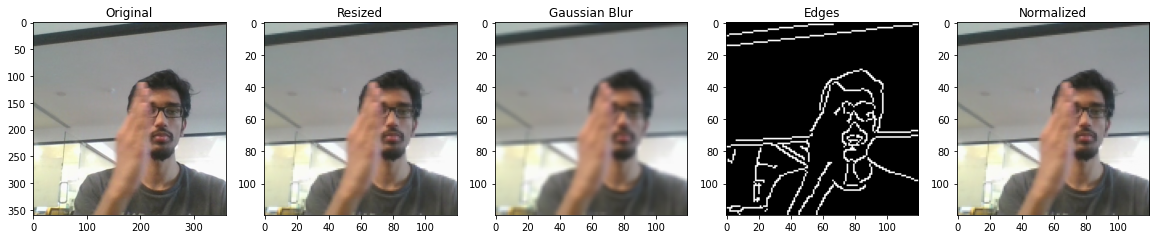



Image for Swipe Right:


original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


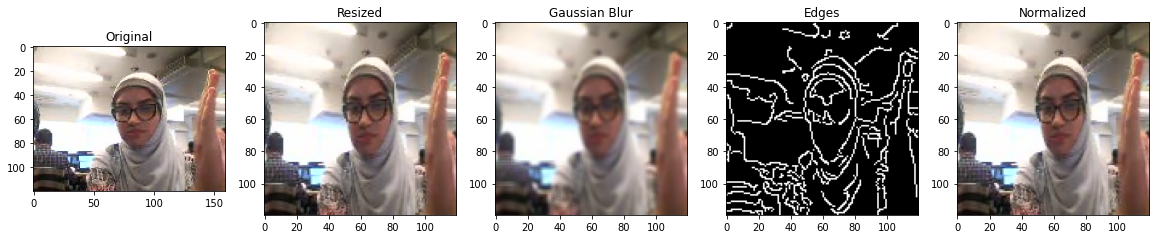

original: (360, 360, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


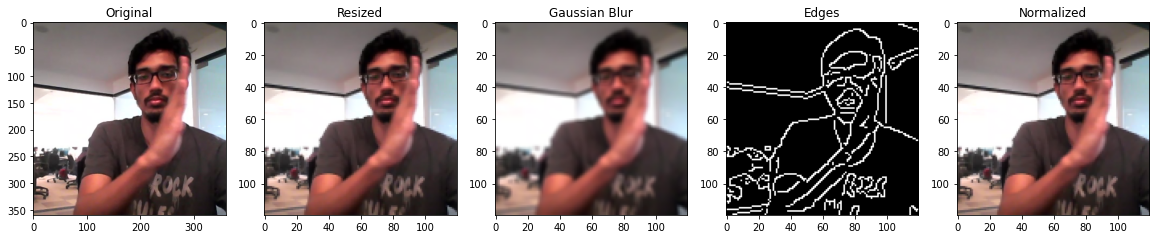



Image for Stop:


original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


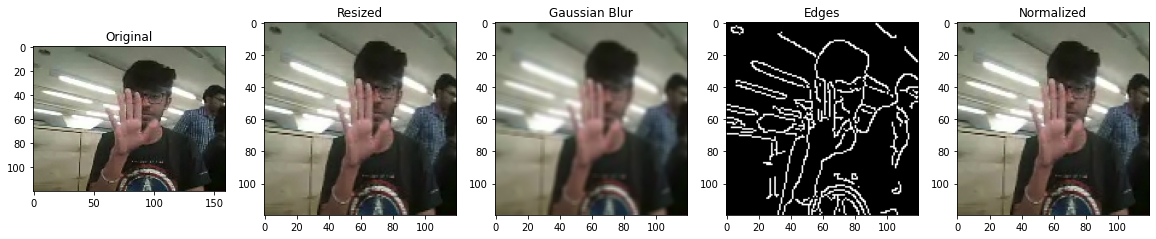

original: (360, 360, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


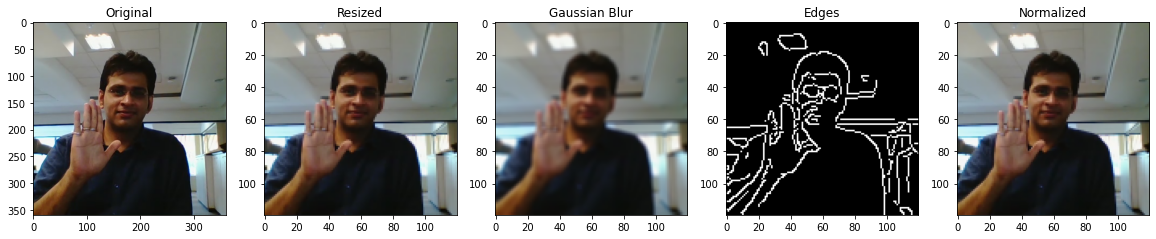



Image for Volume Down:


original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


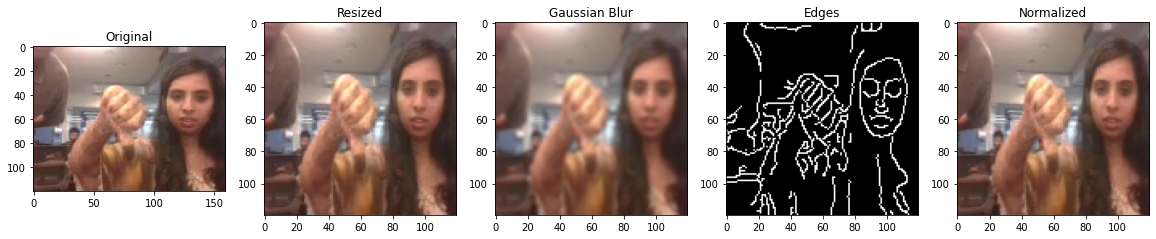

original: (360, 360, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


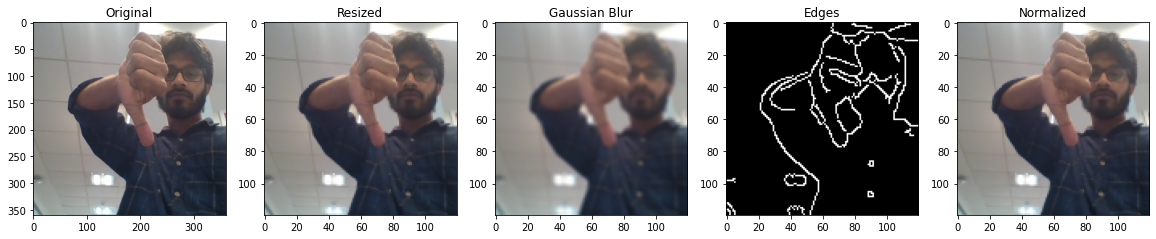



Image for Volume Up:


original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


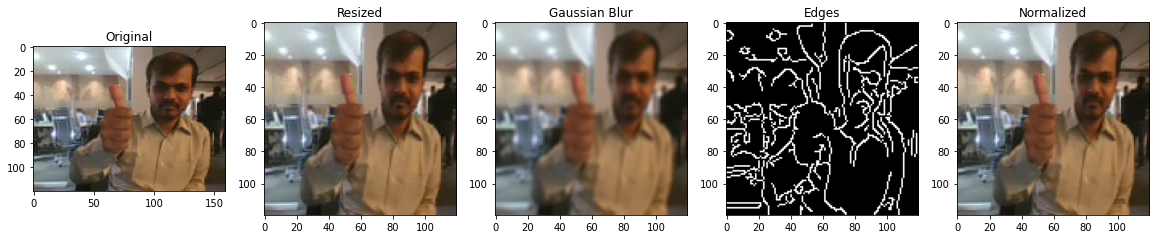

original: (360, 360, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


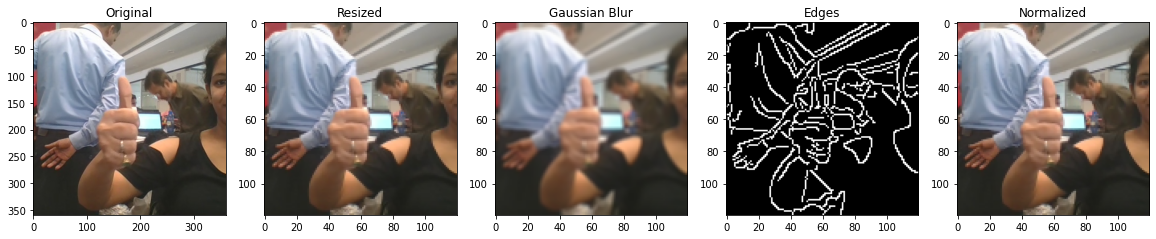

In [ ]:
#Viewing the images with augmented output
print('\033[1m' + 'Image for Swipe Left:' + '\033[0m')
print('\n')
imageview(class_0_120, '/content/gdrive/MyDrive/Project_data/train')
imageview(class_0_360, '/content/gdrive/MyDrive/Project_data/train')

print('\n')
print('\033[1m' + 'Image for Swipe Right:' + '\033[0m')
print('\n')
imageview(class_1_120, '/content/gdrive/MyDrive/Project_data/train')
imageview(class_1_360, '/content/gdrive/MyDrive/Project_data/train')

print('\n')
print('\033[1m' + 'Image for Stop:' + '\033[0m')
print('\n')
imageview(class_2_120, '/content/gdrive/MyDrive/Project_data/train')
imageview(class_2_360, '/content/gdrive/MyDrive/Project_data/train')

print('\n')
print('\033[1m' + 'Image for Volume Down:' + '\033[0m')
print('\n')
imageview(class_3_120, '/content/gdrive/MyDrive/Project_data/train')
imageview(class_3_360, '/content/gdrive/MyDrive/Project_data/train')

print('\n')
print('\033[1m' + 'Image for Volume Up:' + '\033[0m')
print('\n')
imageview(class_4_120, '/content/gdrive/MyDrive/Project_data/train')
imageview(class_4_360, '/content/gdrive/MyDrive/Project_data/train')

In [10]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].grid()
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].grid()
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. 

In [11]:
# The generator function
def generator(source_path, folder_list, batch_size, num_frames, frame_height, frame_width, augment):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    # Based on the number of frames, some frames can be skipped in between. Use linspace function to do that
    img_idx = np.round(np.linspace(5, 25, num_frames)).astype(int) #create a list of image numbers you want to use for a particular video

    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)//batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size, num_frames, frame_height, frame_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            batch_data_blur = np.zeros((batch_size, num_frames, frame_height, frame_width, 3))
            batch_data_edge = np.zeros((batch_size, num_frames, frame_height, frame_width, 3))           
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Resize the Images maintaining the aspect ratio
                    image_resized = cv2.resize(image, (frame_height,frame_width), interpolation = cv2.INTER_AREA)
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the image
                    
                    # Add augmentation (Gaussian Noise Images)
                    if (augment == True):                
                        # Add blurred images
                        image_blur = cv2.GaussianBlur(image_resized,(3,3),3)

                        batch_data_blur[folder,idx,:,:,0] = (image_blur[:,:,0])/255 #normalise and feed in the image
                        batch_data_blur[folder,idx,:,:,1] = (image_blur[:,:,1])/255 #normalise and feed in the image
                        batch_data_blur[folder,idx,:,:,2] = (image_blur[:,:,2])/255 #normalise and feed in the image
                  
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
            if(augment == True):
                # Add blurred images to the data
                batch_data = np.concatenate([batch_data, batch_data_blur])
                batch_labels = np.concatenate([batch_labels, batch_labels])
            
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        remaining_data = len(t) % batch_size
        if(remaining_data != 0):
            
            batch_data = np.zeros((remaining_data, num_frames, frame_height, frame_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_data,5)) # batch_labels is the one hot representation of the output
            batch_data_blur = np.zeros((remaining_data, num_frames, frame_height, frame_width, 3))
            batch_data_edge = np.zeros((remaining_data, num_frames, frame_height, frame_width, 3))           

            for folder in range(remaining_data): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # Resize the Images maintaining the aspect ratio
                    image_resized = cv2.resize(image, (frame_height,frame_width), interpolation = cv2.INTER_AREA)
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the image
                    
                    # Add augmentation (Gaussian Noise Images)
                    if(augment == True):
                        # Add blurred images
                        image_blur = cv2.GaussianBlur(image_resized,(3,3),3)

                        batch_data_blur[folder,idx,:,:,0] = (image_blur[:,:,0])/255 #normalise and feed in the image
                        batch_data_blur[folder,idx,:,:,1] = (image_blur[:,:,1])/255 #normalise and feed in the image
                        batch_data_blur[folder,idx,:,:,2] = (image_blur[:,:,2])/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            if(augment == True):
                # Add blurred images to the data
                batch_data = np.concatenate([batch_data, batch_data_blur])
                batch_labels = np.concatenate([batch_labels, batch_labels])

            yield batch_data, batch_labels 

In [12]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/gdrive/MyDrive/Project_data/train'
val_path = '/content/gdrive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [13]:
mod_path='/content/gdrive/MyDrive/Project_data/'

## Model Creation


In [14]:
# Function to fit and train the Model
def train_model(model, model_name, num_epochs, size_batch, num_frames, frame_height, frame_width, augment):

    # Model with the training data
    train_gen = generator(train_path, train_doc, size_batch, num_frames, frame_height, frame_width, augment)
    # Calculate steps per epoch
    if (len(train_doc)%size_batch) == 0:
        train_steps_per_epoch = int(len(train_doc)/size_batch)
    else:
        train_steps_per_epoch = (len(train_doc)//size_batch) + 1

    # Model with validation data (Augmentation is not applied on the validation data set)
    val_gen = generator(val_path, val_doc, size_batch, num_frames, frame_height, frame_width, augment = False)
    # Calculate steps per epoch
    if (len(val_doc)%size_batch) == 0:
        val_steps_per_epoch = int(len(val_doc)/size_batch)
    else:
        val_steps_per_epoch = (len(val_doc)//size_batch) + 1

    # Callback function to save models   
    curr_dt_time = datetime.datetime.now() # Current date and time to store the models with timestamp
    mod_name = mod_path + model_name + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    if not os.path.exists(mod_name):
        os.mkdir(mod_name)        
    filepath = mod_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', )        
    save_freq="epoch"

    # Callback function to reduce learning rate upon reaching a plateau
    LR = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 4, verbose = 1) # write the REducelronplateau code here
    
    # Early Stop callback function
    earlystop = EarlyStopping(monitor = "val_loss", mode='min', patience = 10, verbose = 1)
    
    # List of all callback functions
    callbacks_list = [checkpoint, LR, earlystop]

    # Fit the model
    history_obj = model.fit_generator(train_gen, steps_per_epoch = train_steps_per_epoch, epochs = num_epochs, verbose = 1,
                                      callbacks = callbacks_list, workers = 1, initial_epoch = 0, class_weight = None,
                                      validation_data = val_gen, validation_steps = val_steps_per_epoch)                                        
  
    return history_obj

Experiment Number:2 Sample Model Creation
Writing a sample model to decide the batch size, image size and number of frames


In [15]:
# Sample model to decide upon the best image size,filter size and dense neuron layer
def model_Conv3D_Test(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (3,3,3), input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
   
    
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
   
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

Experiment Number:1
Deciding on the image size(Experimenting on 100x100,120x120 and 160x160 images respectively)

In [ ]:
# Model:1 Model with image size 100x100, checking the model performance with 100x100 image size

num_frames = 30
frame_height = 100
frame_width = 100
size_batch = 32
num_epochs = 5
augment = False

model = model_Conv3D_Test(num_frames, frame_height, frame_width)
optimiser=tf.keras.optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
train_model(model, 'Conv3D_Test', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 100, 100, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 100, 100, 16)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 50, 50, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 50, 50, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 50, 50, 32)    0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 7, 25, 25, 32)    0         
 3D)                                                    

In [ ]:
#Model:2 Model with image size 120x120
 
num_frames = 30
frame_height = 120
frame_width = 120
size_batch = 32
num_epochs = 5
augment = False

model = model_Conv3D_Test(num_frames, frame_height, frame_width)
#optimiser = optimizers.Adam() 
optimiser=tf.keras.optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
train_model(model, 'Conv3D_Test', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)
#plot(model_history)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_7 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_8 (Activation)   (None, 15, 60, 60, 32)    0         
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 7, 30, 30, 32)    0         
 3D)                                                  

In [ ]:
# Model:3 # with image size 160x160

num_frames = 30
frame_height = 160
frame_width = 160
size_batch = 32
num_epochs = 5
augment = False

model = model_Conv3D_Test(num_frames, frame_height, frame_width)
#optimiser = optimizers.Adam() 
optimiser=tf.keras.optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history=train_model(model, 'Conv3D_Test', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)
#plot(model_history)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_14 (Activation)  (None, 30, 160, 160, 16)  0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_15 (Activation)  (None, 15, 80, 80, 32)    0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 7, 40, 40, 32)    0         
 3D)                                                  

From above models we can use image size as 120x120x3 which will give us an optimum result and some flexibility to an extent on batch size

Experiment Number:3
Choosing the appropriate filter size

In [ ]:
# Model:4 - Conv3D Model with filter size (3,3,3)
def model_Conv3D_1(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (3,3,3), input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
   
    
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
   
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_28 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_29 (Activation)  (None, 15, 60, 60, 32)    0         
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 7, 30, 30, 32)    0         
 g3D)                                                 

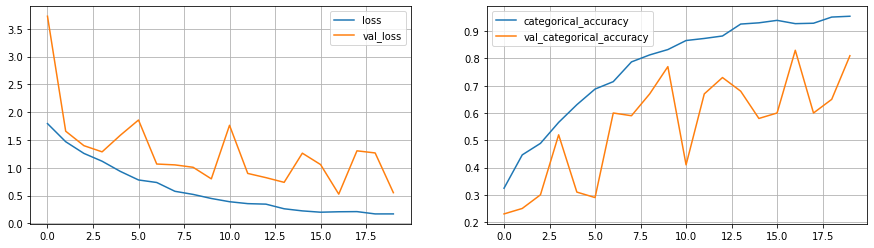

In [ ]:
# Model:4 - Conv3D Model with filter size (3,3,3)
from keras.utils.vis_utils import plot_model
frame_height = 120
frame_width = 120
num_frames = 30
size_batch = 32
num_epochs = 20
augment = False

model = model_Conv3D_1(num_frames, frame_height, frame_width)
optimiser=tf.keras.optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = train_model(model, 'Conv3D_1', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)
#modelplot(model_history)
plot(model_history)

As we can see model with 3x3x3 filter overfits, lets check the model with 2x2x2 filter, with some fine tuning we can generate an optimized model out of it

In [ ]:
# Model:5 - Conv3D Model with filter size (2,2,2)
def model_Conv3D_2(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (2,2,2), input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
   
    
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
   
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 120, 120, 16)  400       
                                                                 
 activation_35 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_36 (Activation)  (None, 15, 60, 60, 32)    0         
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 7, 30, 30, 32)    0         
 g3D)                                                 

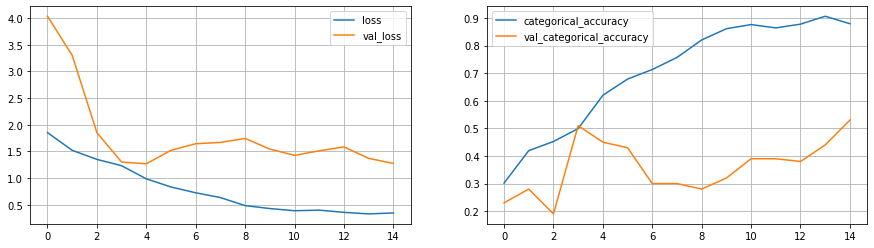

In [ ]:
# Model:5 - Conv3D Model with filter size (2,2,2)

num_frames = 30
frame_height = 120
frame_width = 120
size_batch = 32
num_epochs = 20
augment = False

model = model_Conv3D_2(num_frames, frame_height, frame_width)
optimiser=tf.keras.optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = train_model(model, 'Conv3D_2', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)
plot(model_history)

From the above results we can infer 3x3x3 filter can provide a better result

Experiment Number:4

In [ ]:
# Model:6 - Conv3D model with dropouts at each convolution layer
def model_Conv3D_3(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (3,3,3), input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Dropout(0.2))  
    
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.2))
  
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.2))
   
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_42 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 15, 60, 60, 16)    0         
                                                                 
 conv3d_25 (Conv3D)          (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_43 (Activation)  (None, 15, 60, 60, 32)    0         
                                                      

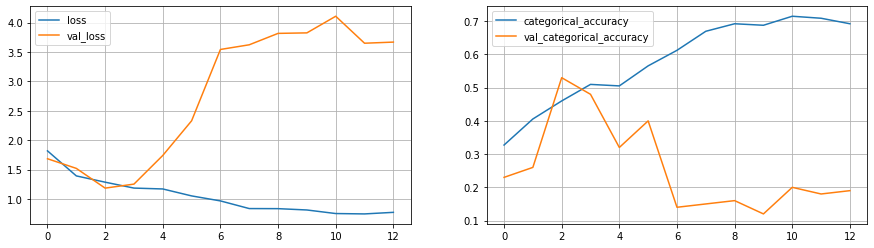

In [ ]:
# Model:6 - Conv3D model with dropouts at each convolution layer

num_frames = 30
frame_height = 120
frame_width = 120
size_batch = 32
num_epochs = 20
augment = False

model = model_Conv3D_3(num_frames, frame_height, frame_width)
optimiser=tf.keras.optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = train_model(model, 'Conv3D_3', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)
plot(model_history)

Experiment:5 Model building with different dense neurons(128 and 64)

The model result shows dropout is at every convolution layer is not helping as it overfits the model

In [ ]:
# Model:7 - Conv3D model with 128 dense neurons
def model_Conv3D_4(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (3,3,3), input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
   
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_49 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_50 (Activation)  (None, 15, 60, 60, 32)    0         
                                                                 
 max_pooling3d_29 (MaxPoolin  (None, 7, 30, 30, 32)    0         
 g3D)                                                 

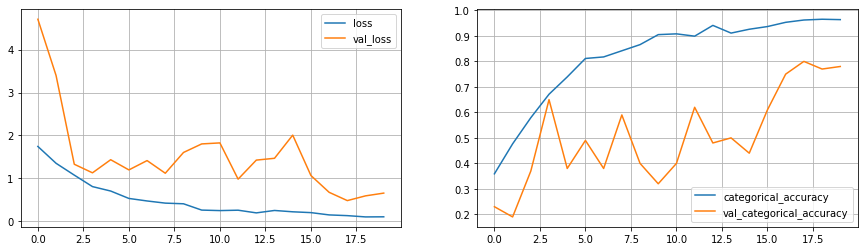

In [ ]:
# Model:7 - Conv3D model with 128 dense neurons

num_frames = 30
frame_height = 120
frame_width = 120
size_batch = 32
num_epochs = 20
augment = False

model = model_Conv3D_4(num_frames, frame_height, frame_width)
optimiser=tf.keras.optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = train_model(model, 'Conv3D_4', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)
plot(model_history)

In [ ]:
# Model:8 - Conv3D model with 64 dense neurons
def model_Conv3D_5(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (3,3,3), input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
   
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_7 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_8 (Activation)   (None, 15, 60, 60, 32)    0         
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 7, 30, 30, 32)    0         
 3D)                                                  

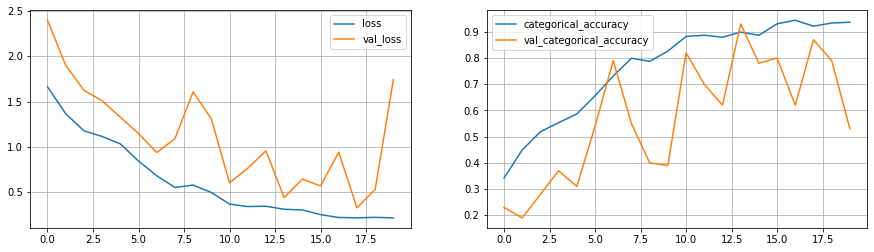

In [ ]:
# Model:8 - Conv3D model with 64 dense neurons

num_frames = 30
frame_height = 120
frame_width = 120
size_batch = 32
num_epochs = 20
augment = False

model = model_Conv3D_5(num_frames, frame_height, frame_width)
optimiser=tf.keras.optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = train_model(model, 'Conv3D_5', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)
plot(model_history)

We can see there is not much difference in terms of choosing the dense layers lets keep the dense neurons as 64 only

In [ ]:
# Model:9 - Conv3D model with SGD optimizer
def model_Conv3D_6(num_frames, frame_height, frame_width):

   model = Sequential()
   model.add(Conv3D(16, (3,3,3), input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
   model.add(Activation('relu'))
   model.add(MaxPooling3D(pool_size=(2,2,2)))
    
   model.add(Conv3D(32, (2, 2, 2), padding='same'))
   model.add(Activation('relu'))
   model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  
   model.add(Conv3D(64, (2, 2, 2), padding='same'))
   model.add(Activation('relu'))
   model.add(MaxPooling3D(pool_size=(2, 2, 2)))
   
    
   model.add(Conv3D(128, (2, 2, 2), padding='same'))
   model.add(Activation('relu'))
   model.add(MaxPooling3D(pool_size=(2, 2, 2)))

   model.add(Flatten())

   model.add(Dense(64))
   model.add(Activation('relu'))
   model.add(BatchNormalization())
   model.add(Dropout(0.5))

   model.add(Dense(64))
   model.add(Activation('relu'))
   model.add(BatchNormalization())
   model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
   model.add(Dense(5))
   model.add(Activation('softmax'))
    
   return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_14 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_15 (Activation)  (None, 15, 60, 60, 32)    0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 7, 30, 30, 32)    0         
 3D)                                                  

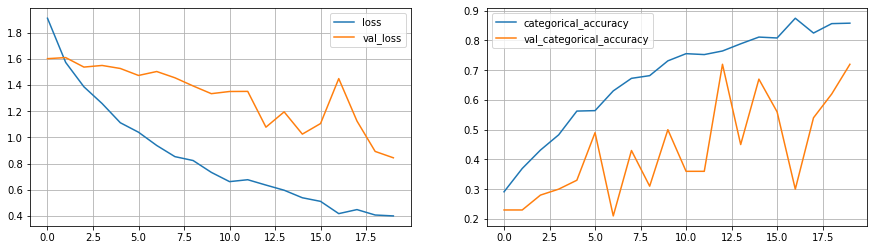

In [ ]:
# Model:9 - Conv3D model with SGD optimizer

num_frames = 30
frame_height = 120
frame_width = 120
size_batch = 32
num_epochs = 20
augment = False

model = model_Conv3D_6(num_frames, frame_height, frame_width)
optimiser = tf.keras.optimizers.SGD()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = train_model(model, 'Conv3D_6', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)
plot(model_history)

Experiment Number:7
Model building with and without augmentation

In [ ]:
# Model:10 - Conv3D model without augmentation
def model_Conv3D_7(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (3,3,3), input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
   
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_21 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_22 (Activation)  (None, 15, 60, 60, 32)    0         
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 7, 30, 30, 32)    0         
 g3D)                                                 

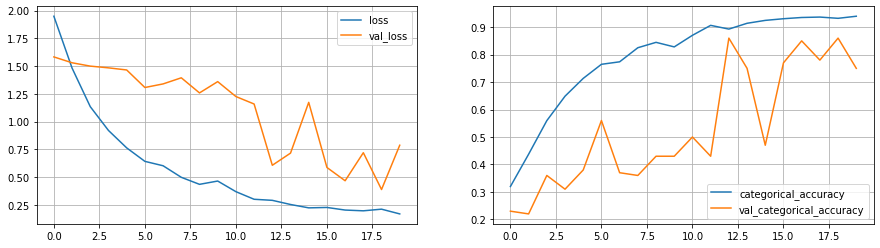

In [ ]:
# Model:10 - Conv3D model without augmentation

num_frames = 30
frame_height = 120
frame_width = 120
size_batch = 32
# From here onwards, we will try 100 epochs (and also allow the Early Stopping to kick in if model performance 
# starts to drop) so that model gets more chance to get trained
num_epochs = 20
augment = False

model = model_Conv3D_7(num_frames, frame_height, frame_width)
optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = train_model(model, 'Conv3D_7', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)
plot(model_history)

In [ ]:
# Model:11 - Conv3D model with augmentation 
def model_Conv3D_8(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(Conv3D(16, (3,3,3), input_shape = (num_frames, frame_height, frame_width, 3),     
                     padding = 'same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    
    model.add(Conv3D(32, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  
    model.add(Conv3D(64, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
   
    
    model.add(Conv3D(128, (2, 2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_7 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_8 (Activation)   (None, 15, 60, 60, 32)    0         
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 7, 30, 30, 32)    0         
 3D)                                                  

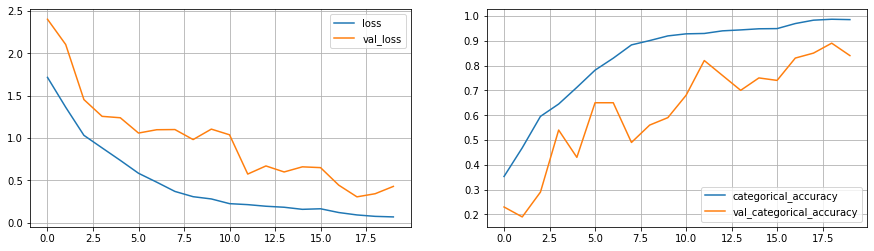

In [ ]:
# Model:11 - Conv3D model with augmentation (same model as Model 7 but with additional augmentation data)

num_frames = 30
frame_height = 120
frame_width = 120
size_batch = 32
num_epochs = 20
augment = True

model = model_Conv3D_8(num_frames, frame_height, frame_width)
optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())
# Run the model and check accuracy
model_history = train_model(model, 'Conv3D_8', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)
plot(model_history)

Experiment Number:8
Building a LSTM model

In [16]:
# Model:12 - CNN LSTM Model
def model_LSTM_9(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same'), input_shape = (num_frames, frame_height, frame_width, 3)))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Conv2D(128, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.5))

    model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))    
    model.add(Dropout(0.5))
    
    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(units=128, return_sequences=True, activation='tanh', recurrent_dropout=0.5))
    model.add(Dropout(0.5))
 
    model.add(LSTM(units=50, activation='tanh', recurrent_dropout=0.5))
    model.add(Dropout(0.5))
   
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

In [17]:
# Model:12 - CNN LSTM Model

num_frames = 10
frame_height = 120
frame_width = 120
size_batch = 32
num_epochs = 20
augment = True
model = model_LSTM_9(num_frames, frame_height, frame_width)
optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 120, 120, 16)  208      
 ibuted)                                                         
                                                                 
 activation (Activation)     (None, 10, 120, 120, 16)  0         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 60, 60, 32)   2080      
 tributed)                                              

In [18]:
model_history = train_model(model, 'LSTM_12', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.5521 - categorical_accuracy: 0.2896  Source path =  /content/gdrive/MyDrive/Project_data/val ; batch size = 32

Epoch 1: saving model to /content/gdrive/MyDrive/Project_data/LSTM_9_2022-08-2114_20_07.856845/model-00001-1.55212-0.28959-1.62670-0.16000.h5
21/21 [==============================] - 1919s 95s/step - loss: 1.5521 - categorical_accuracy: 0.2896 - val_loss: 1.6267 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.2590 - categorical_accuracy: 0.4849
Epoch 2: saving model to /content/gdrive/MyDrive/Project_data/LSTM_9_2022-08-2114_20_07.856845/model-00002-1.25897-0.48492-1.62249-0.21000.h5
21/21 [==============================] - 32s 2s/step - loss: 1.2590 - categorical_accuracy: 0.4849 - val_loss: 1.6225 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
21/21 

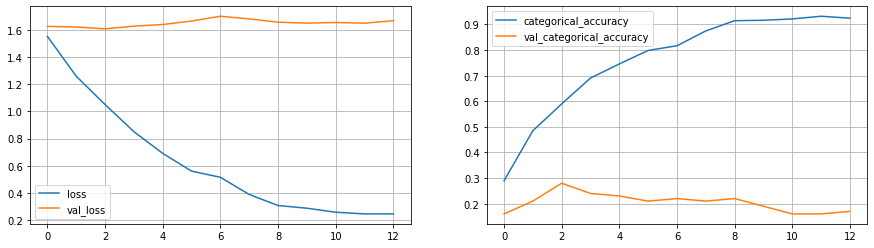

In [19]:
plot(model_history)

Experiment Number:9
Building a GRU model

In [20]:
# Model:13 - CNN GRU Model
def model_GRU_10(num_frames, frame_height, frame_width):

    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (2, 2), padding='same'), input_shape = (num_frames, frame_height, frame_width, 3)))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Conv2D(128, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(Dropout(0.5))

    model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same')))
    model.add(Activation('relu'))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))    
    model.add(Dropout(0.5))
    
    model.add(TimeDistributed(Flatten()))
    
    model.add(GRU(units=128, return_sequences=True, activation='tanh', recurrent_dropout=0.5))
    model.add(Dropout(0.5))
 
    model.add(GRU(units=50, activation='tanh', recurrent_dropout=0.5))
    model.add(Dropout(0.5))
    
    # Final softmax layer for the 5 classes
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    return model

In [21]:
# Model:13 - CNN GRU Model

num_frames = 16
frame_height = 120
frame_width = 120
size_batch = 32
num_epochs = 20
augment = True

model = model_GRU_10(num_frames, frame_height, frame_width)
optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer = optimiser, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 16, 120, 120, 16)  208      
 stributed)                                                      
                                                                 
 activation_6 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 time_distributed_17 (TimeDi  (None, 16, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 16, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 60, 60, 32)   2080      
 stributed)                                           

In [22]:
# Run the model and check accuracy
model_history = train_model(model, 'GRU_13', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.7474 - categorical_accuracy: 0.2775  Source path =  /content/gdrive/MyDrive/Project_data/val ; batch size = 32

Epoch 1: saving model to /content/gdrive/MyDrive/Project_data/GRU_13_2022-08-2115_02_20.860962/model-00001-1.74737-0.27753-1.76566-0.16000.h5
21/21 [==============================] - 1535s 76s/step - loss: 1.7474 - categorical_accuracy: 0.2775 - val_loss: 1.7657 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.4230 - categorical_accuracy: 0.3944
Epoch 2: saving model to /content/gdrive/MyDrive/Project_data/GRU_13_2022-08-2115_02_20.860962/model-00002-1.42297-0.39442-2.06673-0.16000.h5
21/21 [==============================] - 49s 2s/step - loss: 1.4230 - categorical_accuracy: 0.3944 - val_loss: 2.0667 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/20
21/21 

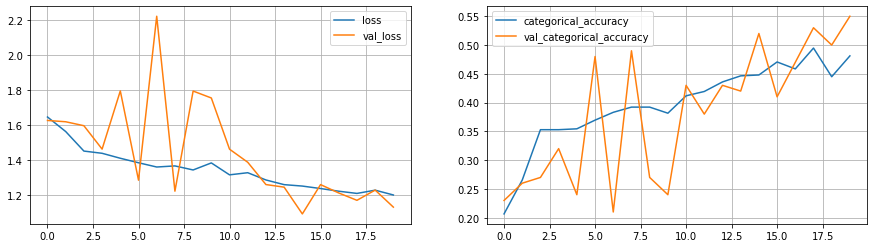

In [ ]:
plot(model_history)

Experiment Number: 10

Building a RESNET50 LSTM model

In [24]:
# Model:14 - RESNET50 LSTM Model
def model_RESNET50(num_frames, frame_height, frame_width):

    num_class = 5
    
    def create_base():
        conv_base = ResNet50(weights='imagenet',
                          include_top=False,
                          input_shape=(frame_height, frame_width, 3))
        count=0
        for layer in conv_base.layers:
            count = count+1
        print("num of layers in resnet50 " + str(count))
        # training the model after 140 layers
        split_at = 170
        for layer in conv_base.layers[:split_at]: layer.trainable = False
        for layer in conv_base.layers[split_at:]: layer.trainable = True
        x = GlobalAveragePooling2D()(conv_base.output)
        base_model = Model(conv_base.input, x)
        return base_model
    
    conv_base = create_base()
    
    ip = Input(shape=(num_frames, frame_height, frame_width, 3))
    t_conv = TimeDistributed(conv_base)(ip) 
    drop_l = Dropout(0.5)(t_conv)
    t_lstm1 = LSTM(units=128, return_sequences=True, activation='tanh', dropout=0.5, recurrent_dropout=0.5)(drop_l)
    
    t_lstm2 = LSTM(units=50, return_sequences=False, activation='tanh', dropout=0.5, recurrent_dropout=0.5)(t_lstm1)

    f_softmax = Dense(num_class, activation='softmax')(t_lstm2)

    model = Model(ip, f_softmax)
    
    return model

In [25]:
# Model:14 - RESNET50 LSTM transfer Learning Model

num_frames = 10
# RESNET50 has a constraint that the minimum image size is 197x197.
frame_height = 197
frame_width = 197
# Because of larger image size, RESNET50 model causes out of memory errors, so we have compensated it with a smaller
# batch size of 25
size_batch = 25
num_epochs = 20
augment = True

model = model_RESNET50(num_frames, frame_height, frame_width)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())

94781440/94765736 [==============================] - 0s 0us/step
num of layers in resnet50 175


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 197, 197, 3)  0         
                             ]                                   
                                                                 
 time_distributed_32 (TimeDi  (None, 10, 2048)         23587712  
 stributed)                                                      
                                                                 
 dropout_10 (Dropout)        (None, 10, 2048)          0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 128)           1114624   
                                                                 
 lstm_3 (LSTM)               (None, 50)                35800     
                                                                 
 dense_2 (Dense)             (None, 5)                 255 

In [26]:
# Run the model and check accuracy
model_history = train_model(model, 'RESNET50', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 25
Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 1.6529 - categorical_accuracy: 0.1802Source path =  /content/gdrive/MyDrive/Project_data/val ; batch size = 25

Epoch 1: saving model to /content/gdrive/MyDrive/Project_data/RESNET50_2022-08-2115_45_53.664980/model-00001-1.65286-0.18024-1.60770-0.23000.h5
27/27 [==============================] - 61s 2s/step - loss: 1.6529 - categorical_accuracy: 0.1802 - val_loss: 1.6077 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 1.6014 - categorical_accuracy: 0.2285
Epoch 2: saving model to /content/gdrive/MyDrive/Project_data/RESNET50_2022-08-2115_45_53.664980/model-00002-1.60142-0.22851-1.57504-0.20000.h5
27/27 [==============================] - 50s 2s/step - loss: 1.6014 - categorical_accuracy: 0.2285 - val_loss: 1.5750 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
27/27 [

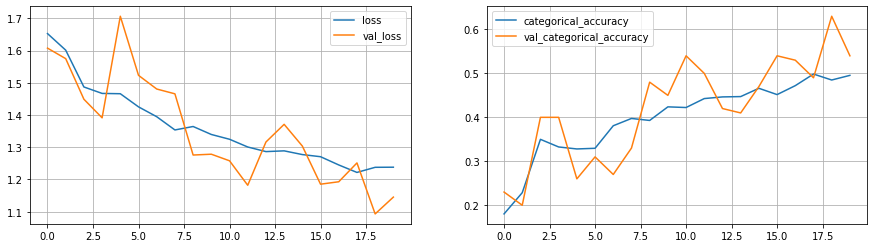

In [27]:
plot(model_history)

Experiment Number: 11

VGG16 LSTM model

In [28]:
# Model:15 - VGG16 LSTM Model
def model_VGG16(num_frames, frame_height, frame_width):

    num_class = 5
    
    def create_base():
        conv_base = VGG16(weights='imagenet',
                          include_top=False,
                          input_shape=(frame_height, frame_width, 3))
        count=0
        for layer in conv_base.layers:
            count = count+1
        print("num of layers in resnet50 " + str(count))
        # training the model after 140 layers
        split_at = 17
        for layer in conv_base.layers[:split_at]: layer.trainable = False
        for layer in conv_base.layers[split_at:]: layer.trainable = True
        x = GlobalAveragePooling2D()(conv_base.output)
        base_model = Model(conv_base.input, x)
        return base_model
    
    conv_base = create_base()
    
    ip = Input(shape=(num_frames, frame_height, frame_width, 3))
    t_conv = TimeDistributed(conv_base)(ip) 
    drop_l = Dropout(0.5)(t_conv)
    t_lstm1 = LSTM(units=128, return_sequences=True, activation='tanh', dropout=0.5, recurrent_dropout=0.5)(drop_l)
    
    t_lstm2 = LSTM(units=64, return_sequences=False, activation='tanh', dropout=0.5, recurrent_dropout=0.5)(t_lstm1)

    f_softmax = Dense(num_class, activation='softmax')(t_lstm2)

    model = Model(ip, f_softmax)
    
    return model

In [29]:
# Model:15 - VGG16 transfer Learning Model

num_frames = 10
frame_height = 120
frame_width = 120
size_batch = 32
num_epochs = 20
augment = True

model = model_VGG16(num_frames, frame_height, frame_width)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
print(model.summary())

58900480/58889256 [==============================] - 0s 0us/step
num of layers in resnet50 19


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed_33 (TimeDi  (None, 10, 512)          14714688  
 stributed)                                                      
                                                                 
 dropout_11 (Dropout)        (None, 10, 512)           0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 128)           328192    
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [30]:
# Run the model and check accuracy
model_history = train_model(model, 'VGG16', num_epochs, size_batch, num_frames, frame_height, frame_width, augment)

Source path =  /content/gdrive/MyDrive/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.5404 - categorical_accuracy: 0.2979Source path =  /content/gdrive/MyDrive/Project_data/val ; batch size = 32

Epoch 1: saving model to /content/gdrive/MyDrive/Project_data/VGG16_2022-08-2116_05_40.448133/model-00001-1.54041-0.29789-1.28619-0.48000.h5
21/21 [==============================] - 53s 2s/step - loss: 1.5404 - categorical_accuracy: 0.2979 - val_loss: 1.2862 - val_categorical_accuracy: 0.4800 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.3182 - categorical_accuracy: 0.4457
Epoch 2: saving model to /content/gdrive/MyDrive/Project_data/VGG16_2022-08-2116_05_40.448133/model-00002-1.31815-0.44570-1.01558-0.60000.h5
21/21 [==============================] - 33s 2s/step - loss: 1.3182 - categorical_accuracy: 0.4457 - val_loss: 1.0156 - val_categorical_accuracy: 0.6000 - lr: 0.0010
Epoch 3/20
21/21 [======

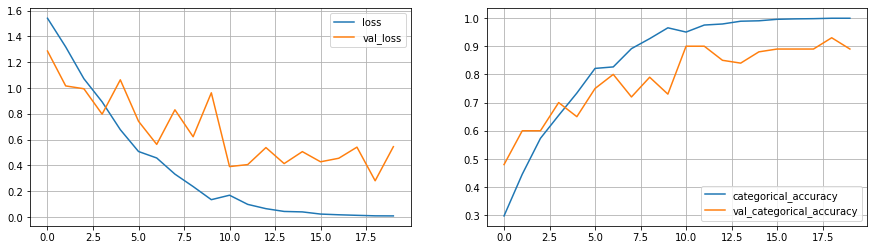

In [31]:
plot(model_history)

Selecting the best model

As we can see VGG16 appears to be the best model in terms of performance amongst the experiments(Model:15)

In Conv3D models, model with Augmentation does a decent job(Model Number:11

Loading the winner models and testing samples

Model 11: Conv3D with augmentation

In [35]:
model = load_model('/content/gdrive/MyDrive/Project_data/Conv3D_8_2022-08-2103_47_26.001679/model-00020-0.06803-0.98492-0.42802-0.84000.h5')

In [39]:
# Test the model using one random image from the validation data set

# Get one random image from validation data set
one_img = generator(val_path, val_doc, batch_size = 1, num_frames = 30, 
                    frame_height = 120, frame_width = 120, augment = True)
one_img_data, one_img_label = next(one_img)

# Actual Class
print('Actual Class of the Image:    ', list(one_img_label[0]).index(1))

# Predicted Class from the model
print('Predicted Class of the Image: ', np.argmax(model.predict(one_img_data), axis = 1)[0])


Source path =  /content/gdrive/MyDrive/Project_data/val ; batch size = 1
Actual Class of the Image:     1
Predicted Class of the Image:  1


Model:15 VGG16 model

In [40]:
model = load_model('/content/gdrive/MyDrive/Project_data/VGG16_2022-08-2116_05_40.448133/model-00020-0.00761-0.99925-0.54440-0.89000.h5')

In [45]:
# Test the model using one random image from the validation data set

# Get one random image from validation data set
one_img = generator(val_path, val_doc, batch_size = 1, num_frames = 10, 
                    frame_height = 120, frame_width = 120, augment = True)
one_img_data, one_img_label = next(one_img)

# Actual Class
print('Actual Class of the Image:    ', list(one_img_label[0]).index(1))

# Predicted Class from the model
print('Predicted Class of the Image: ', np.argmax(model.predict(one_img_data), axis = 1)[0])


Source path =  /content/gdrive/MyDrive/Project_data/val ; batch size = 1
Actual Class of the Image:     1
Predicted Class of the Image:  1
